# Import libraries

In [34]:

import datetime as dt
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import h2o
import sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from math import radians, sin, cos, sqrt, atan2
from shapely.geometry import Polygon
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from statsmodels.tools.tools import add_constant

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML
from tpot import TPOTClassifier
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
import sys
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score,rand_score,fowlkes_mallows_score
from sklearn.cluster import DBSCAN,KMeans,AgglomerativeClustering,MeanShift
import mlflow
import mlflow.sklearn
import pickle
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
os.environ["LOGNAME"] = "ML-Project"
mlflow.set_experiment(experiment_name="ML Project Group 11")

<Experiment: artifact_location='mlflow-artifacts:/333203481596531553', creation_time=1701239176812, experiment_id='333203481596531553', last_update_time=1701239176812, lifecycle_stage='active', name='ML Project Group 11', tags={}>

# Load the cleaned and preprocessed data

In [3]:
accidents_sub = pd.read_csv("C:\\Users\\reza3\\OneDrive\\Desktop\\AIT\\Machine learning\\group project\\data\\accidents_sub.csv")

# create train and test data

In [4]:
X = accidents_sub.drop(columns=['Unnamed: 0', 'ID', 'Severity', 'Delay(min)', 'Street', 'City', 'County', 'State', 'Zipcode',
       'Start_Year', 'Start_Month', 'Start_Day', "Wind_Chill(C)",
       'Start_time','Distance(km)', 'Delay_ln', 'Severity_new'])
Y = accidents_sub.loc[:, ['Severity', 'Severity_new', 'Delay(min)', 'Delay_ln', 'Distance(km)']]


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047692 entries, 0 to 3047691
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Start_Lat             float64
 1   Start_Lng             float64
 2   Humidity(%)           float64
 3   Crossing              int64  
 4   Junction              int64  
 5   Stop                  int64  
 6   Traffic_Signal        int64  
 7   Sunrise_Sunset        int64  
 8   Civil_Twilight        int64  
 9   Start_Hour            int64  
 10  IsWeekend             int64  
 11  Temperature(C)        float64
 12  Pressure(cm)          float64
 13  Precipitation(cm)     float64
 14  Visibility(km)        float64
 15  Wind_Speed(kmph)      float64
 16  Weather_Bin_Clear     int64  
 17  Weather_Bin_Cloudy    int64  
 18  Weather_Bin_Rainy     int64  
 19  Weather_Bin_Snowy     int64  
 20  Start_Month_December  int64  
 21  Start_Month_January   int64  
dtypes: float64(8), int64(14)
memory usage: 511

In [6]:
X.shape, Y.shape

((3047692, 22), (3047692, 5))

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y["Severity_new"], test_size = 0.10, random_state=370, stratify=Y["Severity_new"])

assert len(X_train)  == len(Y_train)
assert len(X_test)   == len(Y_test)
print("train set shape:", X_train.shape,Y_train.shape, "test set shape: ", X_test.shape, Y_test.shape)

train set shape: (2742922, 22) (2742922,) test set shape:  (304770, 22) (304770,)


# Fixing imbalance classes

In [8]:
# Imbalance classes of the label is severe, so first I created a new feature named severity_new and the tried different methods to deal with imbalance
accidents_sub["Severity_new"].value_counts(sort=False)

Severity_new
0    2775400
1     272292
Name: count, dtype: int64

In [ ]:
'''# fixing imbalance by under sampling (Tomek links) (it didn't help)
tl = TomekLinks(n_jobs=-1, sampling_strategy="Majority")

# fit predictor and target variable
X_train_tl, Y_train_tl = tl.fit_resample(X_train, Y_train["Severity_new"])'''

In [9]:
# fixing imbalance by under sampling (random under sampling without replacement)
rus = RandomUnderSampler(random_state=370, replacement=False)

# fit predictor and target varialbe
X_train_rus, Y_train_rus = rus.fit_resample(X_train, Y_train)

print("train set shape:", X_train_rus.shape,Y_train_rus.shape)

train set shape: (490126, 22) (490126,)


# Regression Model
I tried to fit a regression model with Delay and distance as labels but no appropriate model have found. 

In [ ]:
'''model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=370)

model.fit(X_train, Y_train["Distance(km)"])

# Make predictions on the validation set
y_train_pred = model.predict(X_train)

# Calculate metrics
mse = mean_squared_error(Y_train["Distance(km)"], y_train_pred)
r2 = r2_score(Y_train["Distance(km)"], y_train_pred)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R_squared on Test Set: {r2}')'''




# Classification models

In [14]:
from mlflow.data.pandas_dataset import PandasDataset

lr = LogisticRegression(random_state=370, n_jobs=-1)
rf = RandomForestClassifier(random_state=370, n_jobs=-1)
xgb = xgboost.XGBClassifier(max_depth=1, n_estimators=200, n_jobs=-1)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.001, random_state=370)

# models = [ lr, rf, sgb, ada]
models = {"Logistic Regression": lr, "Random Forest":rf, "xgboost":xgb, "Adaboost":ada}

dataset: PandasDataset = mlflow.data.from_pandas(X_train_rus, source='')


#perform cross validation using KFold
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits = 5, shuffle = True, random_state=370)
for name,model in models.items():
    with mlflow.start_run(run_name=f"{name} Model ", nested=True):
        mlflow.log_input(dataset, context="training")
        score = cross_val_score(model, X_train_rus, Y_train_rus, cv=kfold, scoring='accuracy', n_jobs=-1)  #f1, recall, precision, accuracy
        print("Model: ", model, "Scores: ", score, "- Scores mean: ", score.mean(), "- Scores std:", score.std()) 
        params = {"Model":model, "Scores":score, "Scores mean":score.mean(), "Scores std ":score.std()}
        mlflow.log_params(params=params)
        fit = model.fit(X_train_rus, Y_train_rus)
        yhat = fit.predict(X_test)
        conf_matrix = confusion_matrix(Y_test, yhat)
        true_positive = conf_matrix[0][0]
        true_negative = conf_matrix[1][1]
        false_positive = conf_matrix[0][1]
        false_negative = conf_matrix[1][0]
        #mlflow.log_metric("true_positive", true_positive)
        #mlflow.log_metric("true_negative", true_negative)
        #mlflow.log_metric("false_positive", false_positive)
        #mlflow.log_metric("false_negative", false_negative)
        #print(confusion_matrix(Y_test, yhat).ravel())
        mlflow.log_metric("ROCAUC_score", roc_auc_score(Y_test, yhat))
        print('ROCAUC score:',roc_auc_score(Y_test, yhat))      
        #print(classification_report(Y_test, yhat))
        cr = classification_report(Y_test, yhat, output_dict=True) 
        mlflow.log_metric("accuracy", cr.pop("accuracy"))
        for class_or_avg, metrics_dict in cr.items():
            for metric, value in metrics_dict.items():
                mlflow.log_metric(class_or_avg + '_' + metric,value)     
        print(classification_report(Y_test, yhat))
        #print("Model saved in run %s" % mlflow.active_run().info.run_uuid)
        #mlflow.sklearn.log_model(fit, name)
       

c:\Users\reza3\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\data\dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\reza3\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
c:\Users\reza3\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\data\pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way

Model:  LogisticRegression(n_jobs=-1, random_state=370) Scores:  [0.6 0.6 0.6 0.6 0.6] - Scores mean:  0.5995335899854665 - Scores std: 0.00165098337682491
ROCAUC score: 0.6047820979048242
              precision    recall  f1-score   support

           0       0.94      0.58      0.72    277541
           1       0.13      0.63      0.21     27229

    accuracy                           0.58    304770
   macro avg       0.53      0.60      0.47    304770
weighted avg       0.87      0.58      0.67    304770

Model:  RandomForestClassifier(n_jobs=-1, random_state=370) Scores:  [0.73 0.73 0.73 0.73 0.73] - Scores mean:  0.7299327146226626 - Scores std: 0.0018975149193138717
ROCAUC score: 0.7359946245304989
              precision    recall  f1-score   support

           0       0.97      0.72      0.82    277541
           1       0.21      0.75      0.33     27229

    accuracy                           0.72    304770
   macro avg       0.59      0.74      0.57    304770
weighted avg

In [12]:
param_grid = {"n_estimators": [100, 200, 300], "criterion": ["gini", "entropy"], "max_depth": np.arange(1, 10)}
model = RandomForestClassifier(n_jobs=-1, random_state=370)
grid = GridSearchCV(model, param_grid, refit=True, n_jobs=-1)
grid.fit(X_train_rus, Y_train_rus)
print(grid.best_params_)
yhat = grid.predict(X_test)
print(classification_report(Y_test, yhat))

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.96      0.58      0.72    277541
           1       0.15      0.75      0.25     27229

    accuracy                           0.59    304770
   macro avg       0.55      0.66      0.48    304770
weighted avg       0.89      0.59      0.68    304770



# The final model

In [19]:
from mlflow.data.pandas_dataset import PandasDataset
final_model = RandomForestClassifier(n_estimators= 300, criterion="gini", max_depth= 9, n_jobs=-1, random_state=370 )

dataset: PandasDataset = mlflow.data.from_pandas(X_train_rus, source='')
with mlflow.start_run(run_name=f"Random Forest Classifier {final_model}"):
        mlflow.log_input(dataset, context="training")
        fit = final_model.fit(X_train_rus, Y_train_rus)
        yhat = fit.predict(X_test)
        conf_matrix = confusion_matrix(Y_test, yhat)
        true_positive = conf_matrix[0][0]
        true_negative = conf_matrix[1][1]
        false_positive = conf_matrix[0][1]
        false_negative = conf_matrix[1][0]
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("false_negative", false_negative)
        print(confusion_matrix(Y_test, yhat).ravel())
        mlflow.log_metric("ROCAUC_score", roc_auc_score(Y_test, yhat))
        print('ROCAUC score:',roc_auc_score(Y_test, yhat))      
        print(classification_report(Y_test, yhat))
        cr = classification_report(Y_test, yhat, output_dict=True) 
        mlflow.log_metric("accuracy", cr.pop("accuracy"))
        for class_or_avg, metrics_dict in cr.items():
            for metric, value in metrics_dict.items():
                mlflow.log_metric(class_or_avg + '_' + metric,value)     
        mlflow.sklearn.log_model(final_model,"ّFinal Model")
        mlflow.end_run()
       

c:\Users\reza3\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\data\dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\reza3\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
c:\Users\reza3\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\data\pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way

[160660 116881   6899  20330]
ROCAUC score: 0.6627499295456922
              precision    recall  f1-score   support

           0       0.96      0.58      0.72    277541
           1       0.15      0.75      0.25     27229

    accuracy                           0.59    304770
   macro avg       0.55      0.66      0.48    304770
weighted avg       0.89      0.59      0.68    304770



# Analyse (Features importance)

C:\Users\reza3\AppData\Local\Temp\ipykernel_2200\2097169851.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( y= feature_importance_sorted[0], x=feature_importance_sorted[1], palette="colorblind")


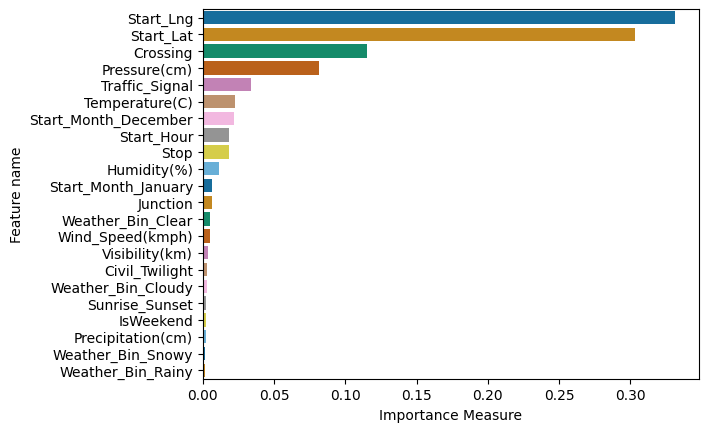

In [24]:
feature_imp = final_model.feature_importances_
feature_names = final_model.feature_names_in_
feature_importance = [feature_names, feature_imp]
len(feature_importance)
df = pd.DataFrame(feature_importance)
df1=df.T
feature_importance_sorted = df1.sort_values(by=1, ascending=False)

sns.barplot( y= feature_importance_sorted[0], x=feature_importance_sorted[1], palette="colorblind")
plt.xlabel("Importance Measure")
plt.ylabel("Feature name")
plt.show()


# Save the model and inference

In [25]:
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)



In [26]:
# Load the model back using pickle
with open('random_forest_model.pkl', 'rb') as file:
    loaded_rf_model = pickle.load(file)

In [30]:
new_data = X_test.iloc[[1000,1680,5, 278, 9606]]  # Your new data here

# Use the loaded model for prediction
predictions = loaded_rf_model.predict(new_data)
print("Prediction:", predictions)

Prediction: [1 0 1 1 1]


In [31]:
yhat_for_all = loaded_rf_model.predict(X)


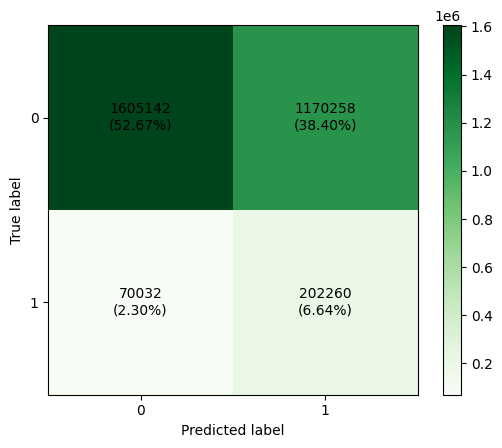

In [46]:
#this is confusion matrix for all sub_accidents data

cm = confusion_matrix(Y["Severity_new"], yhat_for_all)
cmp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])

fig, ax = plt.subplots()
cmp.plot(ax=ax, cmap=plt.cm.Greens)
for text in ax.texts:
    text.set_text("")

# Display integers in each cell
total_samples = cm.sum()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = count / total_samples * 100
        text = f"{count}\n({percentage:.2f}%)"
        ax.text(j, i, text, ha='center', va='center', color='black')
plt.show()

# Some other tries

In [ ]:
'''#fitting model with class weights parameter to fix imbalance
model = RandomForestClassifier(n_estimators= 200, criterion="gini", max_depth= 9, n_jobs=-1, random_state=370, class_weight="balanced_subsample")
model.fit(X_train, Y_train)
yhat = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
print("True Negative = ",tn, " False Negative = ",fn, "True Positive = ", tp, "False Positive = ", fn)
print(classification_report(Y_test, yhat))'''

In [ ]:
'''model = RandomForestClassifier(n_estimators= 200, criterion="gini", max_depth= 9, n_jobs=-1, random_state=370, class_weight="balanced")
model.fit(X_train, Y_train)
yhat = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, yhat).ravel()
print("True Negative = ",tn, " False Negative = ",fn, "True Positive = ", tp, "False Positive = ", fn)
print(classification_report(Y_test, yhat))'''

In [ ]:
'''# Range of clusters to test
n_clusters_range = range(1, 11)
bic_scores = []

# Fit the model for each number of clusters and compute BIC
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_for_cluster)
    
    # BIC (Bayesian Information Criterion) score
    bic_scores.append(gmm.bic(X_for_cluster))

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, bic_scores, marker='o')
plt.title('Elbow Plot for Gaussian Mixture Model')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

# Choose the optimal number of clusters based on the elbow plot
optimal_n_clusters = np.argmin(bic_scores) + 1  # +1 because Python is zero-indexed
print(f'Optimal Number of Clusters: {optimal_n_clusters}')

# Train the model with the optimal number of clusters
optimal_gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
optimal_gmm.fit(X_train)

# Predict the clusters for the testing data
test_labels = optimal_gmm.predict(X_test)

# Evaluate the model on the testing data
test_score = optimal_gmm.score(X_test)
silhouette_score = metrics.silhouette_score(X_test, test_labels)

print(f'Log-Likelihood on Test Data: {test_score}')
print(f'Silhouette Score on Test Data: {silhouette_score}')'''


In [ ]:
'''gmm = GaussianMixture(n_components=5, init_params="random_from_data", random_state=370)
gmm.fit(X_for_cluster)
cluster = gmm.predict(X_for_cluster).astype(int)'''



